# Charging Infrastructure for Electric Vehicles
## Where is the demand?

This notebook is a compilation of the exploratory and statistical analysis of electric charging stations in the US. We start by exploring the relationship between [station count](https://afdc.energy.gov/stations/states) and [EV sales numbers](https://evadoption.com/ev-market-share/ev-market-share-state/) by state. 

In [1]:
%matplotlib inline
from __future__ import print_function

import warnings
import itertools
import numpy as np
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

import geopandas as gpd
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch

# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

PROJ_ROOT = os.pardir

## Importing Data

Both the stations by state and EV sales by state datasets are imported into dataframes from csv files.

In [2]:
sales_data_path = os.path.join(PROJ_ROOT, "data", "raw", "EVShareByState.csv")
station_data_path = os.path.join(PROJ_ROOT, "data", "raw", "StationCountByState.csv")
df = pd.read_csv(sales_data_path)
df1 = pd.read_csv(station_data_path)

In [3]:
# Remove outlet count to keep only station count and store in new column in sales dataframe
df['StationCount'] = pd.to_numeric([(str(x).split(' / ')[0]) for x in df1.StationsOutlets])
df['StateCode'] = df1.StateCode
df['Sales2016'] = pd.to_numeric(df['Sales2016'])

In [4]:
df.head()

,State,Sales2016,Sales2017,Sales2018,2017SalesIncrease,2018SalesIncrease,MarketShare2017,MarketShare2018,2018ShareIncrease,StationCount,StateCode
0,Alabama,330,381,866,0.16,1.27,0.0019,0.0041,1.16,136,AL
1,Alaska,94,85,155,-0.10,0.82,0.0037,0.0059,0.59,19,AK
2,Arizona,2265,2976,7086,0.31,1.38,0.0090,0.0184,1.04,466,AZ
3,Arkansas,138,187,435,0.36,1.33,0.0016,0.0035,1.19,84,AR
4,California,73854,94873,153442,0.29,0.62,0.0502,0.0784,0.56,5706,CA


In [5]:
# Create column for the increase in sales increase from 2017 to 2018
df.loc[df['StateCode']=='GA','2017SalesIncrease'] = 0.01
df['Increase'] = (np.diff([df['2017SalesIncrease']*100,df['2018SalesIncrease']*100],axis=0)[0]/(df['2017SalesIncrease']*100).abs()).round(2)
df.head()

,State,Sales2016,Sales2017,Sales2018,2017SalesIncrease,2018SalesIncrease,MarketShare2017,MarketShare2018,2018ShareIncrease,StationCount,StateCode,Increase
0,Alabama,330,381,866,0.16,1.27,0.0019,0.0041,1.16,136,AL,6.94
1,Alaska,94,85,155,-0.10,0.82,0.0037,0.0059,0.59,19,AK,9.20
2,Arizona,2265,2976,7086,0.31,1.38,0.0090,0.0184,1.04,466,AZ,3.45
3,Arkansas,138,187,435,0.36,1.33,0.0016,0.0035,1.19,84,AR,2.69
4,California,73854,94873,153442,0.29,0.62,0.0502,0.0784,0.56,5706,CA,1.14


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 12 columns):
State                51 non-null object
Sales2016            51 non-null int64
Sales2017            51 non-null int64
Sales2018            51 non-null int64
2017SalesIncrease    51 non-null float64
2018SalesIncrease    51 non-null float64
MarketShare2017      51 non-null float64
MarketShare2018      51 non-null float64
2018ShareIncrease    51 non-null float64
StationCount         51 non-null int64
StateCode            51 non-null object
Increase             51 non-null float64
dtypes: float64(6), int64(4), object(2)
memory usage: 4.9+ KB


## Station Count vs. EV Sales

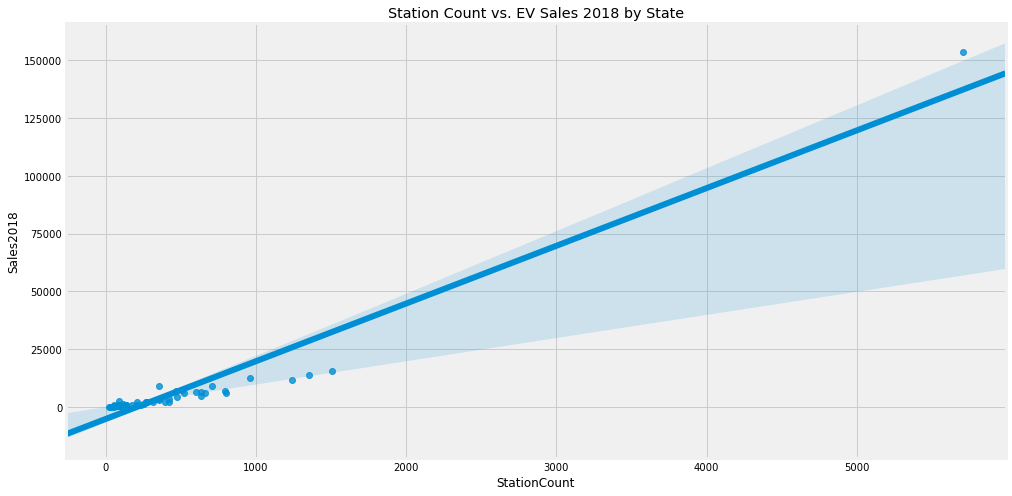

<Figure size 432x288 with 0 Axes>

In [7]:
# Plot station count against sales in 2018
plt.figure(figsize=(15,8))
sns.regplot(y='Sales2018',x='StationCount',data=df,fit_reg=True).set_title('Station Count vs. EV Sales 2018 by State')
plt.show()
plt.savefig('count_vs_sales.png');

## Linear Regression
Here,

$Y$ = electric charging station count for a state (called "target" data in python, and referred to as the dependent variable or response variable)

and

$X$ = EV sales numbers for a state (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict station count. We will use the least-squares method to estimate the coefficients.

In [8]:
# Fit a linear regression model with the ordinary least squares method in statsmodels
m = ols('StationCount ~ Sales2018',df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:           StationCount   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     653.0
Date:                Wed, 18 Dec 2019   Prob (F-statistic):           5.55e-30
Time:                        13:13:00   Log-Likelihood:                -346.45
No. Observations:                  51   AIC:                             696.9
Df Residuals:                      49   BIC:                             700.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    225.0630     32.219      6.985      0.0

We can interpret the Sales2018 coefficient (0.04) by first noticing that the p-value (under P>|t|) is so small, basically zero. This means that EV sales in 2018, Sales2018, is a statistically significant predictor of the number of stations. The regression coefficient for Sales2018 of 0.04 means that on average, each additional electric vehicle sale is associated with an increase in 4 electric charging stations. The confidence interval gives us a range of plausible values for this average change, about (3, 4).

The coefficient of determination (R-squared) shows that 93% of the variance in station count can be explained by this model that uses Sales2018 as the independent variable. The average station count is 225 given that the state sold 0 electric vehicles.

The statistics indicate that the demand for electric vehicles is directly and positively related to the demand for charging stations. This removes bias from the assumption that more electric vehicles means more electric charging stations.

## Exploratory Data Analysis

In [9]:
# Get the descriptive statistics for EV sales and station count
df.describe()

,Sales2016,Sales2017,Sales2018,2017SalesIncrease,2018SalesIncrease,MarketShare2017,MarketShare2018,2018ShareIncrease,StationCount,Increase
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,2854.313725,3686.000000,6433.686275,0.340196,0.947647,0.008129,0.013280,0.801961,464.725490,8.319412
std,10266.368899,13199.075493,21355.045700,0.312995,0.446236,0.008571,0.012828,0.396258,824.808004,21.846250
min,37.000000,39.000000,92.000000,-0.110000,-0.050000,0.001000,0.002200,-0.100000,19.000000,-1.070000
25%,275.000000,375.000000,666.500000,0.135000,0.715000,0.003250,0.005900,0.575000,92.000000,0.845000
50%,855.000000,933.000000,2036.000000,0.290000,0.940000,0.005200,0.009600,0.820000,265.000000,2.330000
75%,2350.000000,2954.000000,6033.500000,0.510000,1.170000,0.009150,0.016100,1.000000,513.500000,4.955000
max,73854.000000,94873.000000,153442.000000,1.630000,2.880000,0.050200,0.078400,2.500000,5706.000000,146.000000


In [10]:
df.sum()

State                AlabamaAlaskaArizonaArkansasCaliforniaColorado...
Sales2016                                                       145570
Sales2017                                                       187986
Sales2018                                                       328118
2017SalesIncrease                                                17.35
2018SalesIncrease                                                48.33
MarketShare2017                                                 0.4146
MarketShare2018                                                 0.6773
2018ShareIncrease                                                 40.9
StationCount                                                     23701
StateCode            ALAKAZARCACOCTDEDCFLGAHIIDILINIAKSKYLAMEMDMAMI...
Increase                                                        424.29
dtype: object

The statistics for sales and station count data by state show that from 2017 to 2018, the sales of electric vehicles increased anywhere from -5% to 290%, and -11% to 163% from 2016 to 2017. The market share of electric vehicles by state increase anywhere from -10% to 250% from 2017 to 2018. Some of these increases reach 2.5 to 3 times the amount of sales and shares in just 1 year! 

The increases in sales increases from 2017 to 2018 range from -107% to 14600%!

Interestingly, the number of stations by state vary as widely as 19 to 5706. The state (California) with the most number of stations (5706) has over 10 times the number of stations in states at the 75th percentile for station count. Perhaps EV charging infrastructure in certain places is not growing fast enough to meet the demand for electric vehicles.

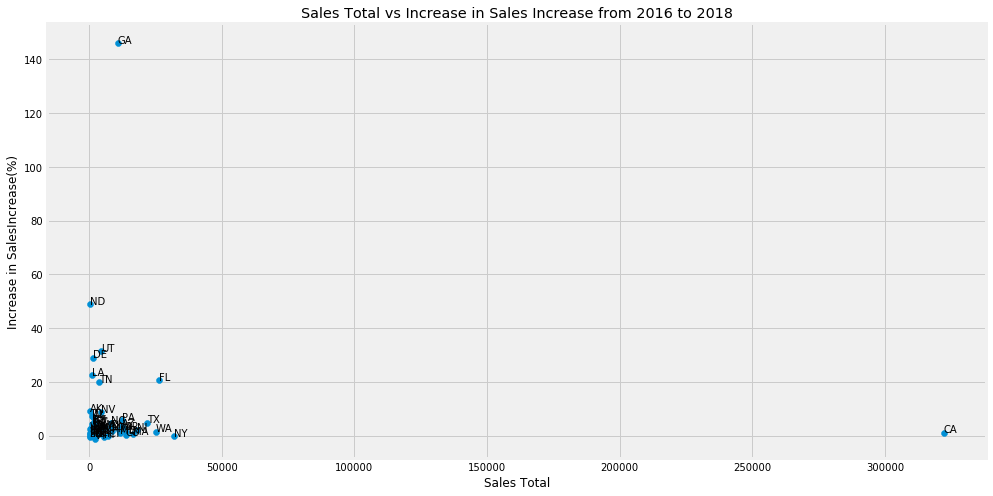

<Figure size 432x288 with 0 Axes>

In [11]:
# Plot the sales totals and the increase in sales increases
fig, ax = plt.subplots(figsize=(15,8))
x = np.sum([df['Sales2016'],df['Sales2017'],df['Sales2018']],axis=0)
y = df.Increase
y = y.reset_index(drop=True)
ax.scatter(x, y)
for i, txt in enumerate(df.StateCode):
    ax.annotate(txt, (x[i], y[i]))
plt.title('Sales Total vs Increase in Sales Increase from 2016 to 2018')
plt.xlabel('Sales Total')
plt.ylabel('Increase in SalesIncrease(%)')
plt.show()
plt.savefig('increase.png');

A scatter plot of the states sales total and increase in sales increase between 2017 and 2018 reveals Georgia as an outstanding state in terms of growing demand for electric vehicles. Georgia sold 8 less electric vehicles in 2017 than in 2016, but in 2018, it sold 3600 more electric vehicles, totaling 6004 EV sales and more than the previous years combined. On the whole, all sales increased over 2 years for all states.

In [12]:
# Create data frame with georgia data for plotting
df_ga = pd.DataFrame({'Year':[2016,2017,2018],
                     'Sales':df.loc[df['StateCode']=='GA',['Sales2016','Sales2017','Sales2018']].to_numpy()[0]})

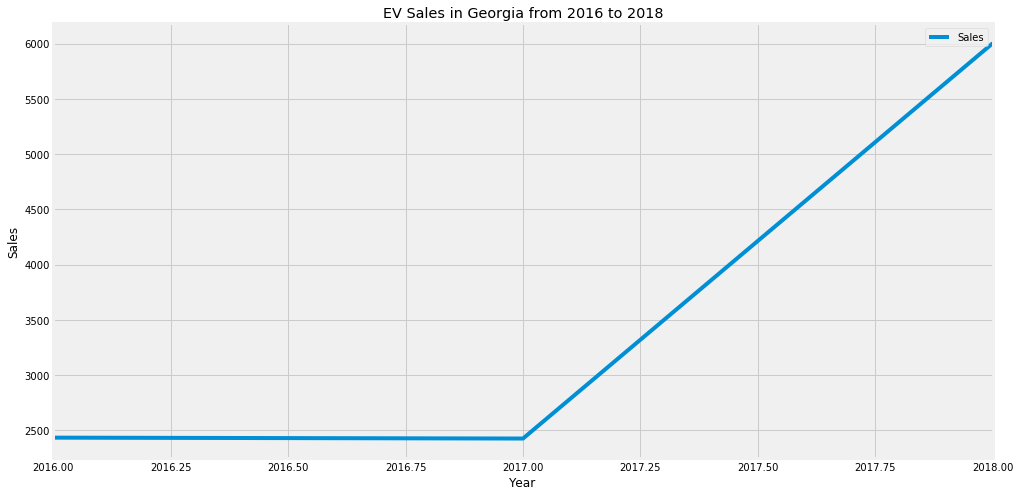

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot the time series of the sales numbers in Georgia
df_ga.plot('Year','Sales',figsize=(15,8))
plt.title('EV Sales in Georgia from 2016 to 2018')
plt.ylabel('Sales')
plt.show()
plt.savefig('georgia_sales.png');

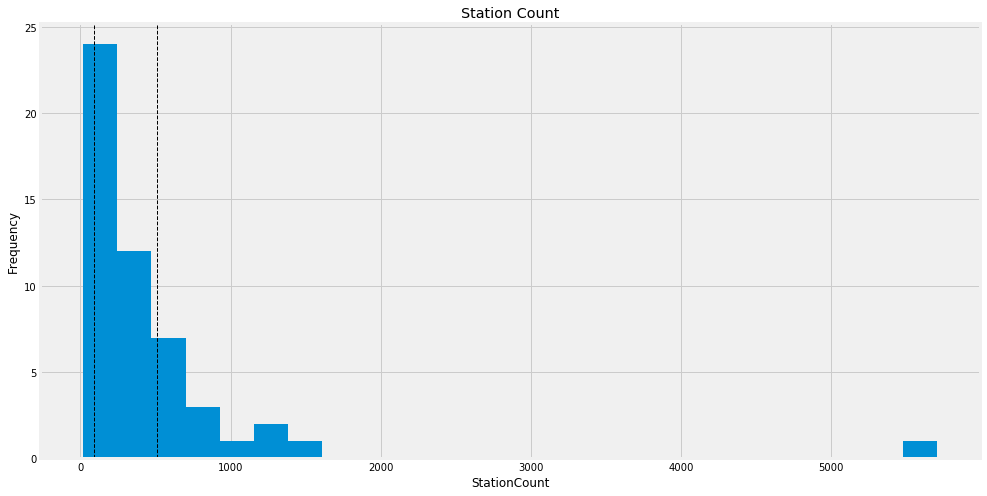

<Figure size 432x288 with 0 Axes>

In [14]:
# Explore the distribution of station count data
plt.figure(figsize=(15,8))
plt.hist(df.StationCount,bins=25)
plt.title('Station Count')
plt.xlabel('StationCount')
plt.ylabel('Frequency')

# Calculate the quartiles
qt_stations = np.percentile(df.StationCount,[25,75])

_ = plt.axvline(qt_stations[0], color='k', linestyle='dashed', linewidth=1)
_ = plt.axvline(qt_stations[1], color='k', linestyle='dashed', linewidth=1)

plt.show()
plt.savefig('station_count.png');

In [15]:
print('Half of the states have between ' + str(qt_stations[0]) + ' to ' + str(qt_stations[1]) + ' stations.')

Half of the states have between 92.0 to 513.5 stations.


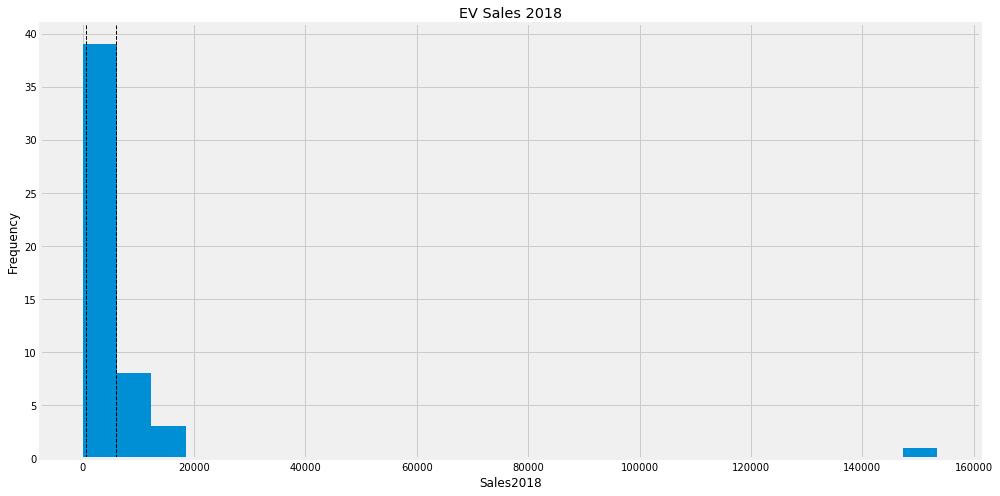

<Figure size 432x288 with 0 Axes>

In [16]:
# Explore the distribution of sales data
plt.figure(figsize=(15,8))
plt.hist(df.Sales2018,bins=25)
plt.title('EV Sales 2018')
plt.xlabel('Sales2018')
plt.ylabel('Frequency')

# Calculate the quartiles
qt_sales = np.percentile(df.Sales2018,[25,75])

_ = plt.axvline(qt_sales[0], color='k', linestyle='dashed', linewidth=1)
_ = plt.axvline(qt_sales[1], color='k', linestyle='dashed', linewidth=1)

plt.show()
plt.savefig('sales2018.png');

In [17]:
print('Half of the states sold between ' + str(qt_sales[0]) + ' to ' + str(qt_sales[1]) + ' electric vehicles in 2018.')

Half of the states sold between 666.5 to 6033.5 electric vehicles in 2018.


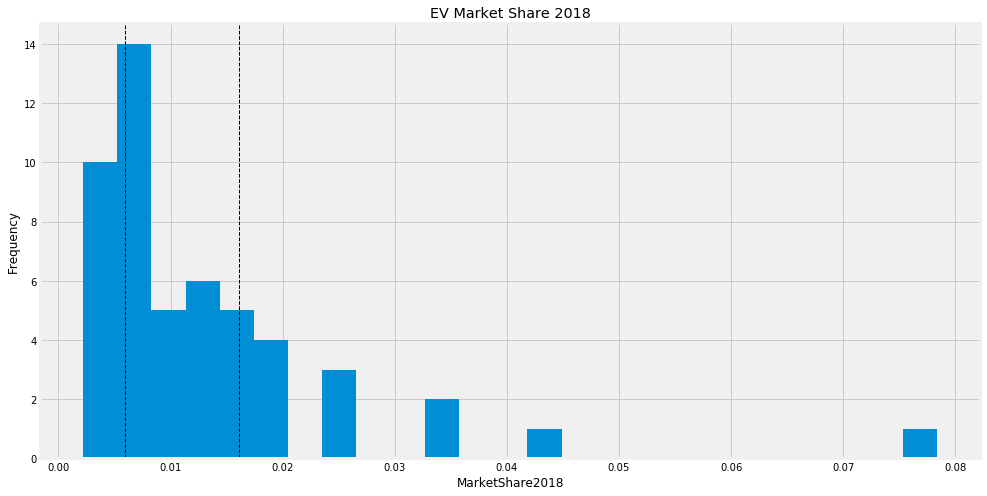

<Figure size 432x288 with 0 Axes>

In [18]:
# Explore the distribution of EV market shares
plt.figure(figsize=(15,8))
plt.hist(df.MarketShare2018,bins=25)
plt.title('EV Market Share 2018')
plt.xlabel('MarketShare2018')
plt.ylabel('Frequency')

# Calculate the quartiles
qt_share = np.percentile(df.MarketShare2018,[25,75])

_ = plt.axvline(qt_share[0], color='k', linestyle='dashed', linewidth=1)
_ = plt.axvline(qt_share[1], color='k', linestyle='dashed', linewidth=1)

plt.show()
plt.savefig('share2018.png');

In [19]:
print('Half of the states have between ' + str(qt_share[0]*100) + ' to ' + str(qt_share[1]*100) + ' percent of EV market share in 2018.')

Half of the states have between 0.59 to 1.6099999999999999 percent of EV market share in 2018.


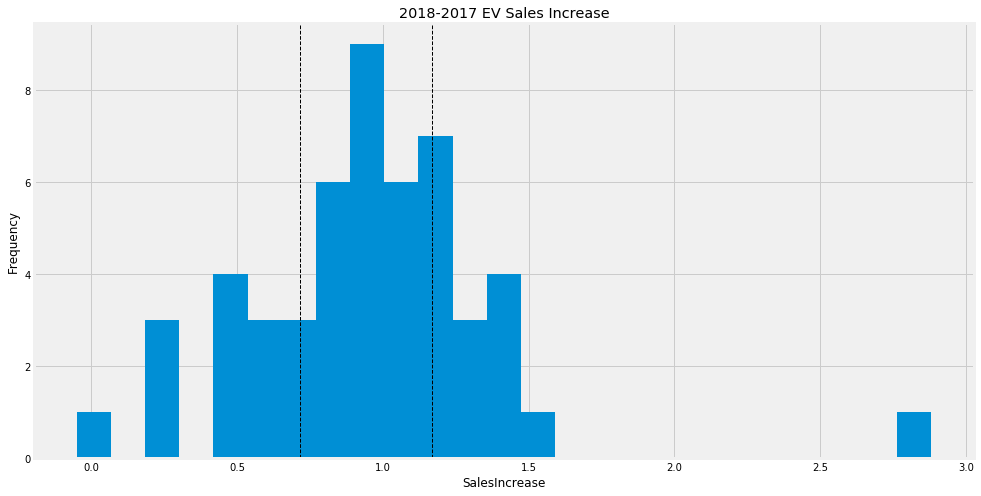

<Figure size 432x288 with 0 Axes>

In [20]:
# Explore the distribution of sales increase
plt.figure(figsize=(15,8))
plt.hist(df['2018SalesIncrease'],bins=25)
plt.title('2018-2017 EV Sales Increase')
plt.xlabel('SalesIncrease')
plt.ylabel('Frequency')

# Calculate the quartiles
qt_salesinc = np.percentile(df['2018SalesIncrease'],[25,75])

_ = plt.axvline(qt_salesinc[0], color='k', linestyle='dashed', linewidth=1)
_ = plt.axvline(qt_salesinc[1], color='k', linestyle='dashed', linewidth=1)

plt.show()
plt.savefig('sales_increase.png');

In [21]:
print('Half of the states increased between ' + str(qt_salesinc[0]*100) + '% to ' + str(qt_salesinc[1]*100) + '% in EV sales from 2017 to 2018.')

Half of the states increased between 71.5% to 117.0% in EV sales from 2017 to 2018.


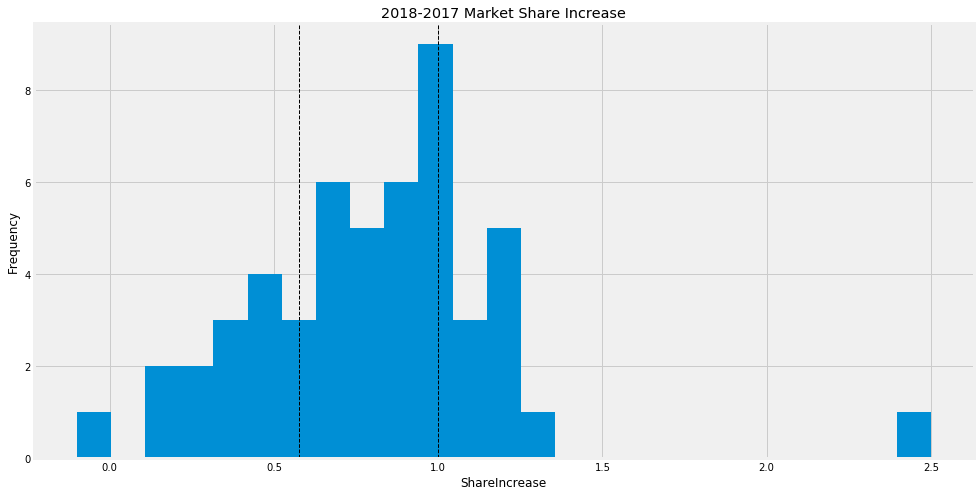

<Figure size 432x288 with 0 Axes>

In [22]:
# Explore the distribution of market share increase
plt.figure(figsize=(15,8))
plt.hist(df['2018ShareIncrease'],bins=25)
plt.title('2018-2017 Market Share Increase')
plt.xlabel('ShareIncrease')
plt.ylabel('Frequency')

# Calculate the quartiles
qt_shareinc = np.percentile(df['2018ShareIncrease'],[25,75])

_ = plt.axvline(qt_shareinc[0], color='k', linestyle='dashed', linewidth=1)
_ = plt.axvline(qt_shareinc[1], color='k', linestyle='dashed', linewidth=1)

plt.show()
plt.savefig('share_increase.png');

In [23]:
print('Half of the states increased between ' + str(qt_shareinc[0]*100) + '% to ' + str(qt_shareinc[1]*100) + '% in EV market share from 2017 to 2018.')

Half of the states increased between 57.49999999999999% to 100.0% in EV market share from 2017 to 2018.


Exploratory analysis show correlations between station count, sales, and market share with similar left-shifted distributions. Correlation also exists between sales increase and market share increase with the two having similar outliers and possible multi-modal distributions. The differing distributions show that sales and share increase are not correlated with station count, sales and market share numbers. Therefore, current station count and sales are not indicators of growth in demand for electric vehicles and charging infrastructure.

## States of Growing Demand for EV

In [24]:
# Get the states with station count below the 75th percentile
few_avg_stations = df[df.StationCount <= qt_stations[1]]

In [25]:
# Get the states with sales and share increase above the 25th percentile from those with few to average station count 
growth_states = few_avg_stations[(few_avg_stations['2018SalesIncrease'] > qt_salesinc[0]) & 
                                 (few_avg_stations['2018ShareIncrease'] > qt_shareinc[0])]
growth_states.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 0 to 48
Data columns (total 12 columns):
State                27 non-null object
Sales2016            27 non-null int64
Sales2017            27 non-null int64
Sales2018            27 non-null int64
2017SalesIncrease    27 non-null float64
2018SalesIncrease    27 non-null float64
MarketShare2017      27 non-null float64
MarketShare2018      27 non-null float64
2018ShareIncrease    27 non-null float64
StationCount         27 non-null int64
StateCode            27 non-null object
Increase             27 non-null float64
dtypes: float64(6), int64(4), object(2)
memory usage: 2.7+ KB


27 states with few to average station count have sales and share increases that indicate above average growth in demand for electric vehicles and charging stations.

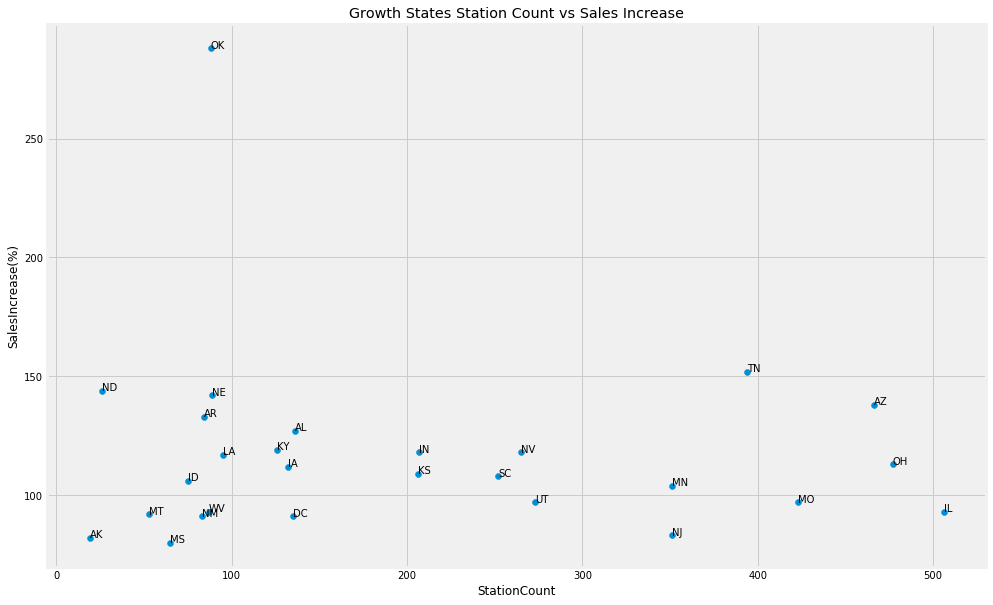

<Figure size 432x288 with 0 Axes>

In [26]:
# Plot the station count and sales increases of the growth states
fig, ax = plt.subplots(figsize=(15,10))
x = growth_states.StationCount
y = growth_states['2018SalesIncrease']*100
x = x.reset_index(drop=True)
y = y.reset_index(drop=True)
ax.scatter(x, y)
for i, txt in enumerate(growth_states.StateCode):
    ax.annotate(txt, (x[i], y[i]))
plt.title('Growth States Station Count vs Sales Increase')
plt.xlabel('StationCount')
plt.ylabel('SalesIncrease(%)')
plt.show()
plt.savefig('growth_states.png');

Plotting the station count against the sales increase of the states with growing demand for electric vehicles further ranks the states by the level of opportunity. In particular, Oklahoma has the highest increase in EV sales out of the growth states but it has less than 100 available charging stations. This shows that Oklahoma has higher potential for ROI when it comes to investment in new charging infrastructure.

In [27]:
df[(df['StateCode'] == 'OK')]

,State,Sales2016,Sales2017,Sales2018,2017SalesIncrease,2018SalesIncrease,MarketShare2017,MarketShare2018,2018ShareIncrease,StationCount,StateCode,Increase
36,Oklahoma,263,691,2683,1.63,2.88,0.001,0.0035,2.5,88,OK,0.77


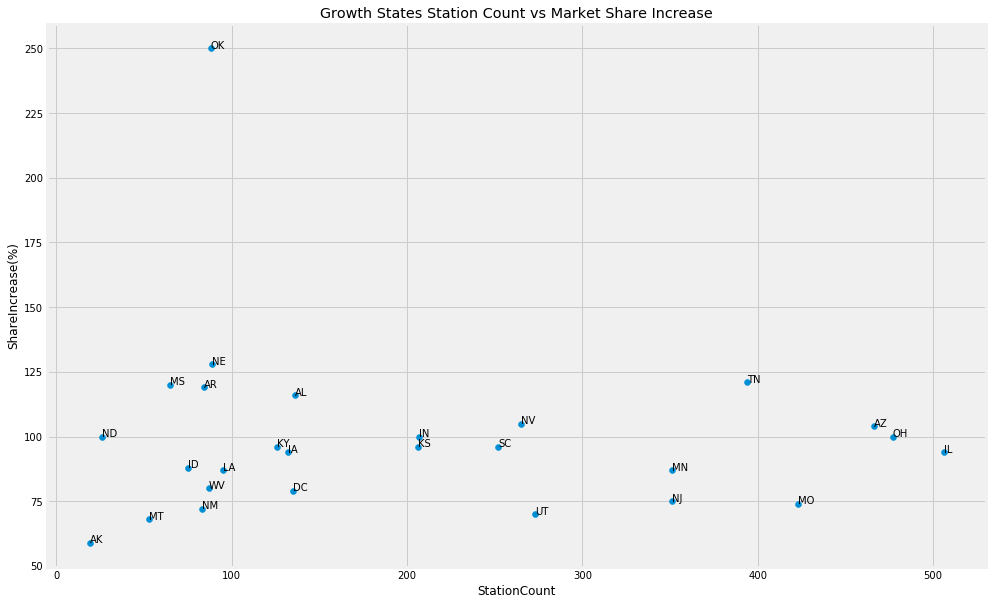

<Figure size 432x288 with 0 Axes>

In [28]:
# Plot the station count and market share increases of the growth states
fig, ax = plt.subplots(figsize=(15,10))
x = growth_states.StationCount
y = growth_states['2018ShareIncrease']*100
x = x.reset_index(drop=True)
y = y.reset_index(drop=True)
ax.scatter(x, y)
for i, txt in enumerate(growth_states.StateCode):
    ax.annotate(txt, (x[i], y[i]))
plt.title('Growth States Station Count vs Market Share Increase')
plt.xlabel('StationCount')
plt.ylabel('ShareIncrease(%)')
plt.show()
plt.savefig('growth_states_share.png');

Plotting the station count and EV market share increase of the states reveals rapid growth in EV demand in Oklahoma with slower growth in charging infrastructure.

In [29]:
# Get the states with station count above the 75th percentile
many_stations = df[df.StationCount > qt_stations[1]]

# Get the states with sales and share increase below the 25th percentile from those with many stations
nongrowth_states = many_stations[many_stations['2018SalesIncrease'] <= qt_salesinc[0]]
nongrowth_states.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 4 to 37
Data columns (total 12 columns):
State                4 non-null object
Sales2016            4 non-null int64
Sales2017            4 non-null int64
Sales2018            4 non-null int64
2017SalesIncrease    4 non-null float64
2018SalesIncrease    4 non-null float64
MarketShare2017      4 non-null float64
MarketShare2018      4 non-null float64
2018ShareIncrease    4 non-null float64
StationCount         4 non-null int64
StateCode            4 non-null object
Increase             4 non-null float64
dtypes: float64(6), int64(4), object(2)
memory usage: 416.0+ bytes


4 states with station count above the 75th percentile have low EV sales and market share increases.

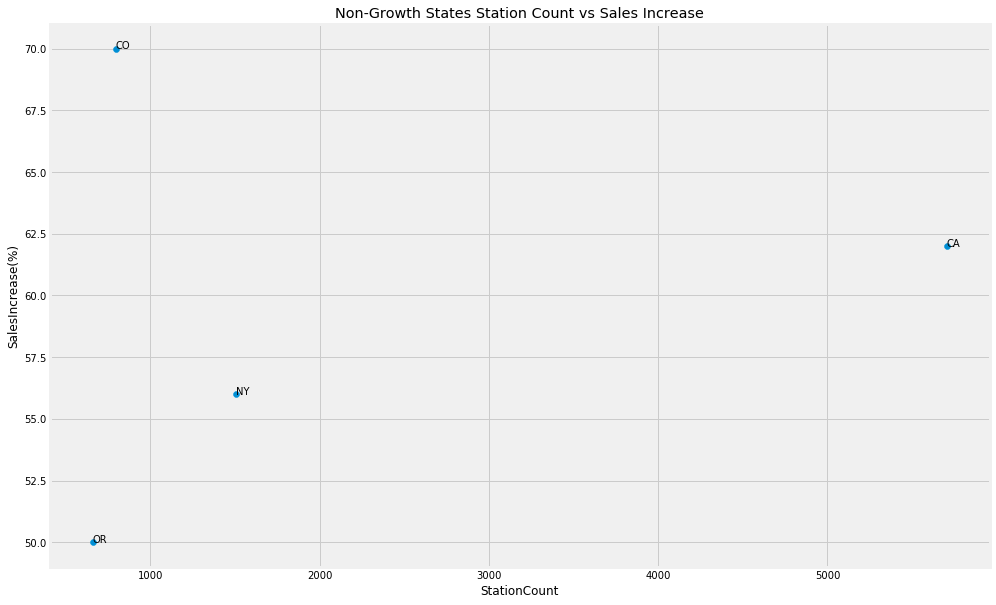

<Figure size 432x288 with 0 Axes>

In [30]:
# Plot the station count and sales increases of the non-growth states
fig, ax = plt.subplots(figsize=(15,10))
x = nongrowth_states.StationCount
y = nongrowth_states['2018SalesIncrease']*100
x = x.reset_index(drop=True)
y = y.reset_index(drop=True)
ax.scatter(x, y)
for i, txt in enumerate(nongrowth_states.StateCode):
    ax.annotate(txt, (x[i], y[i]))
plt.title('Non-Growth States Station Count vs Sales Increase')
plt.xlabel('StationCount')
plt.ylabel('SalesIncrease(%)')
plt.show()
plt.savefig('nongrowth_states.png');

Plotting the station count and sales increase of the non-growth states shows 4 states with saturated markets for EV sales and charging infrastructure.

In [31]:
# Plot the states with growing demand for EV and stations on a map
# Load the GEOJSON file for plotting usa map into a dataframe:
geo_data_path = os.path.join(PROJ_ROOT, "data", "raw", "gz_2010_us_040_00_5m.json")
usa = gpd.read_file(geo_data_path)
usa.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


In [32]:
# Add state codes to usa dataframe
usa['CODE'] = df.StateCode
usa.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,CODE
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ...",AL
1,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752...",AK
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0...",AZ
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079...",AR
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213...",CA


In [33]:
# Create custom function to plot list of states on usa map
def plot_states(states, ng_states, us_map=True): 
    fig, ax = plt.subplots(figsize=(30,30))
    if us_map:
        usa[usa['NAME'].isin(['Alaska','Hawaii']) == False].plot(ax=ax, alpha=0.3)
        for s in states:
            usa[(usa.CODE == f'{s}') & (usa['CODE'].isin(['AK','HI']) == False)].plot(ax=ax, edgecolor = 'g', linewidth=3)
        for n in ng_states:
            usa[(usa.CODE == f'{n}') & (usa['CODE'].isin(['AK','HI']) == False)].plot(ax=ax, color = 'y', edgecolor = 'r', linewidth=3)
    else:
        for s in states:
            usa[(usa.CODE == f'{s}')].plot(ax=ax, edgecolor = 'g', linewidth=3)

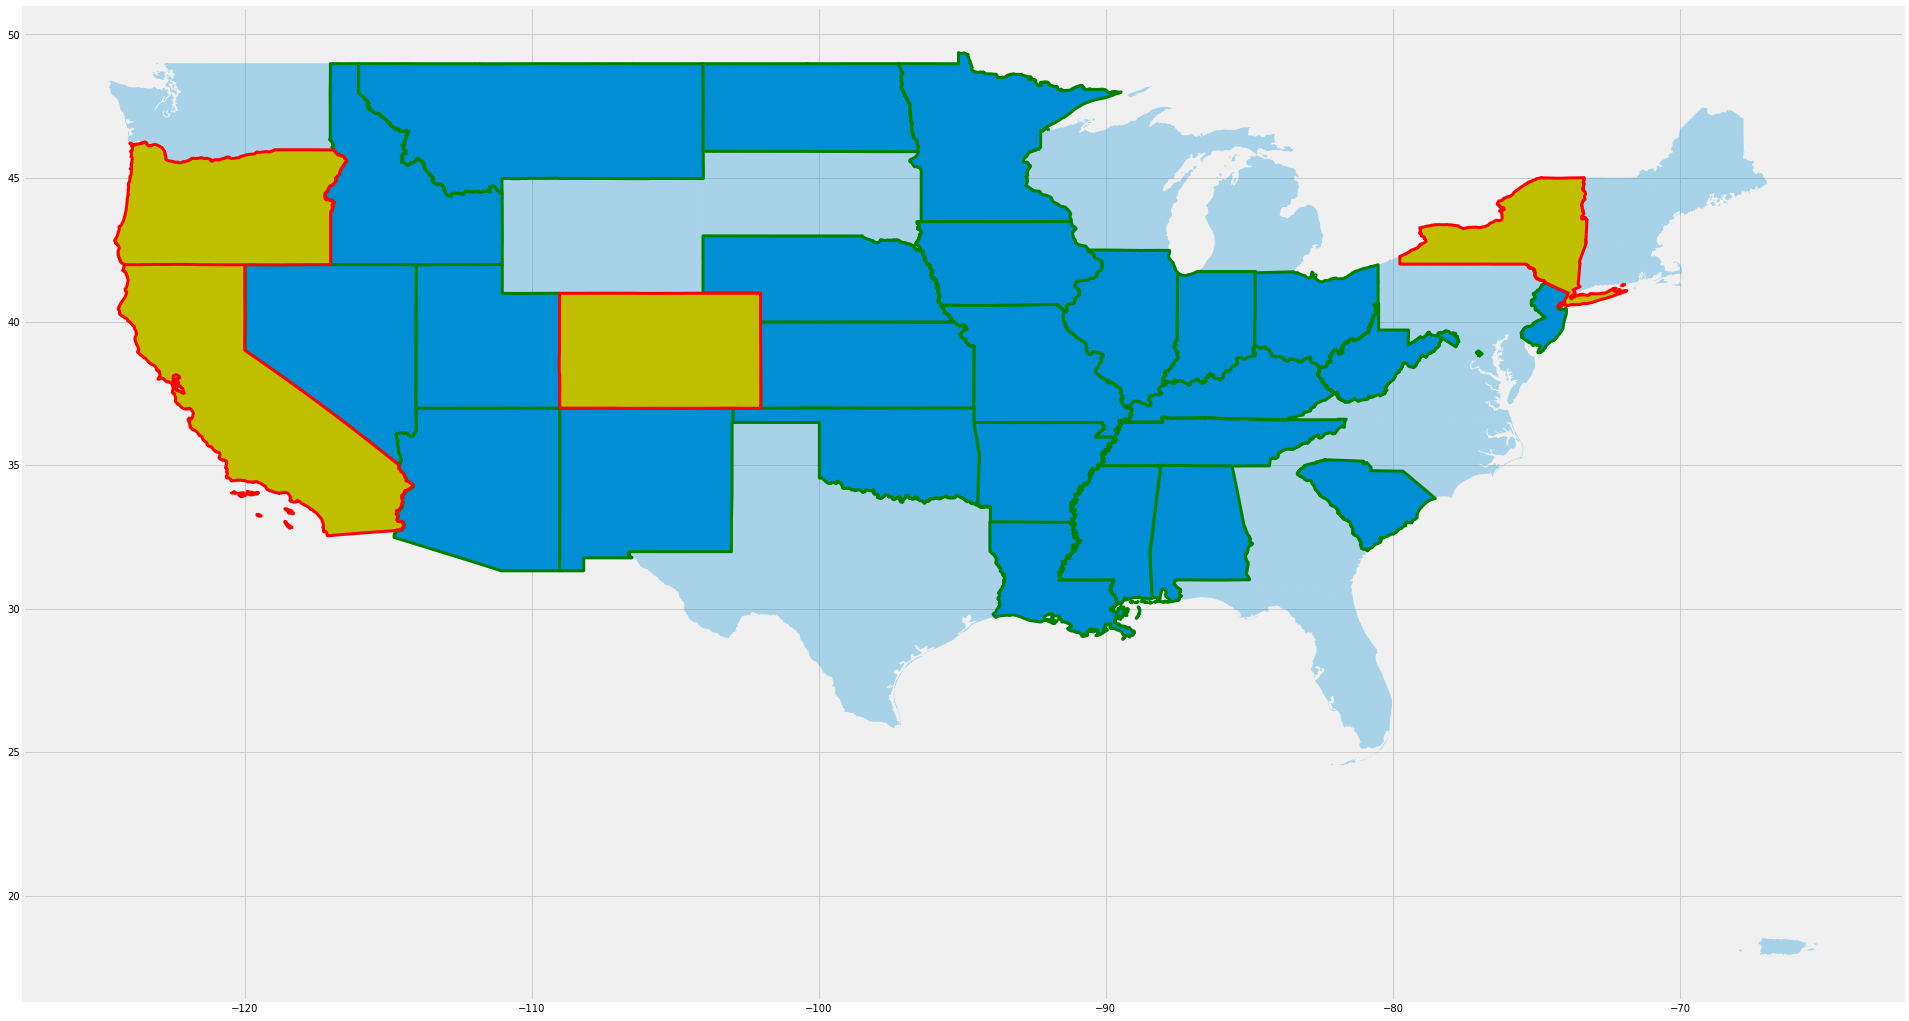

In [34]:
# Plot the states with growing vs. slowing EV demand on the map
plot_states(growth_states.StateCode, nongrowth_states.StateCode)
plt.savefig('growth_states_map.png')

A map of growth vs. non-growth states reveals that the EV markets along the East and West coasts of the US are either highly competitive and more saturated or simply have lower demand for electric vehicles. The North, South, and Midwest have some high potential states when it comes to investment in electric charging stations and EV sales.

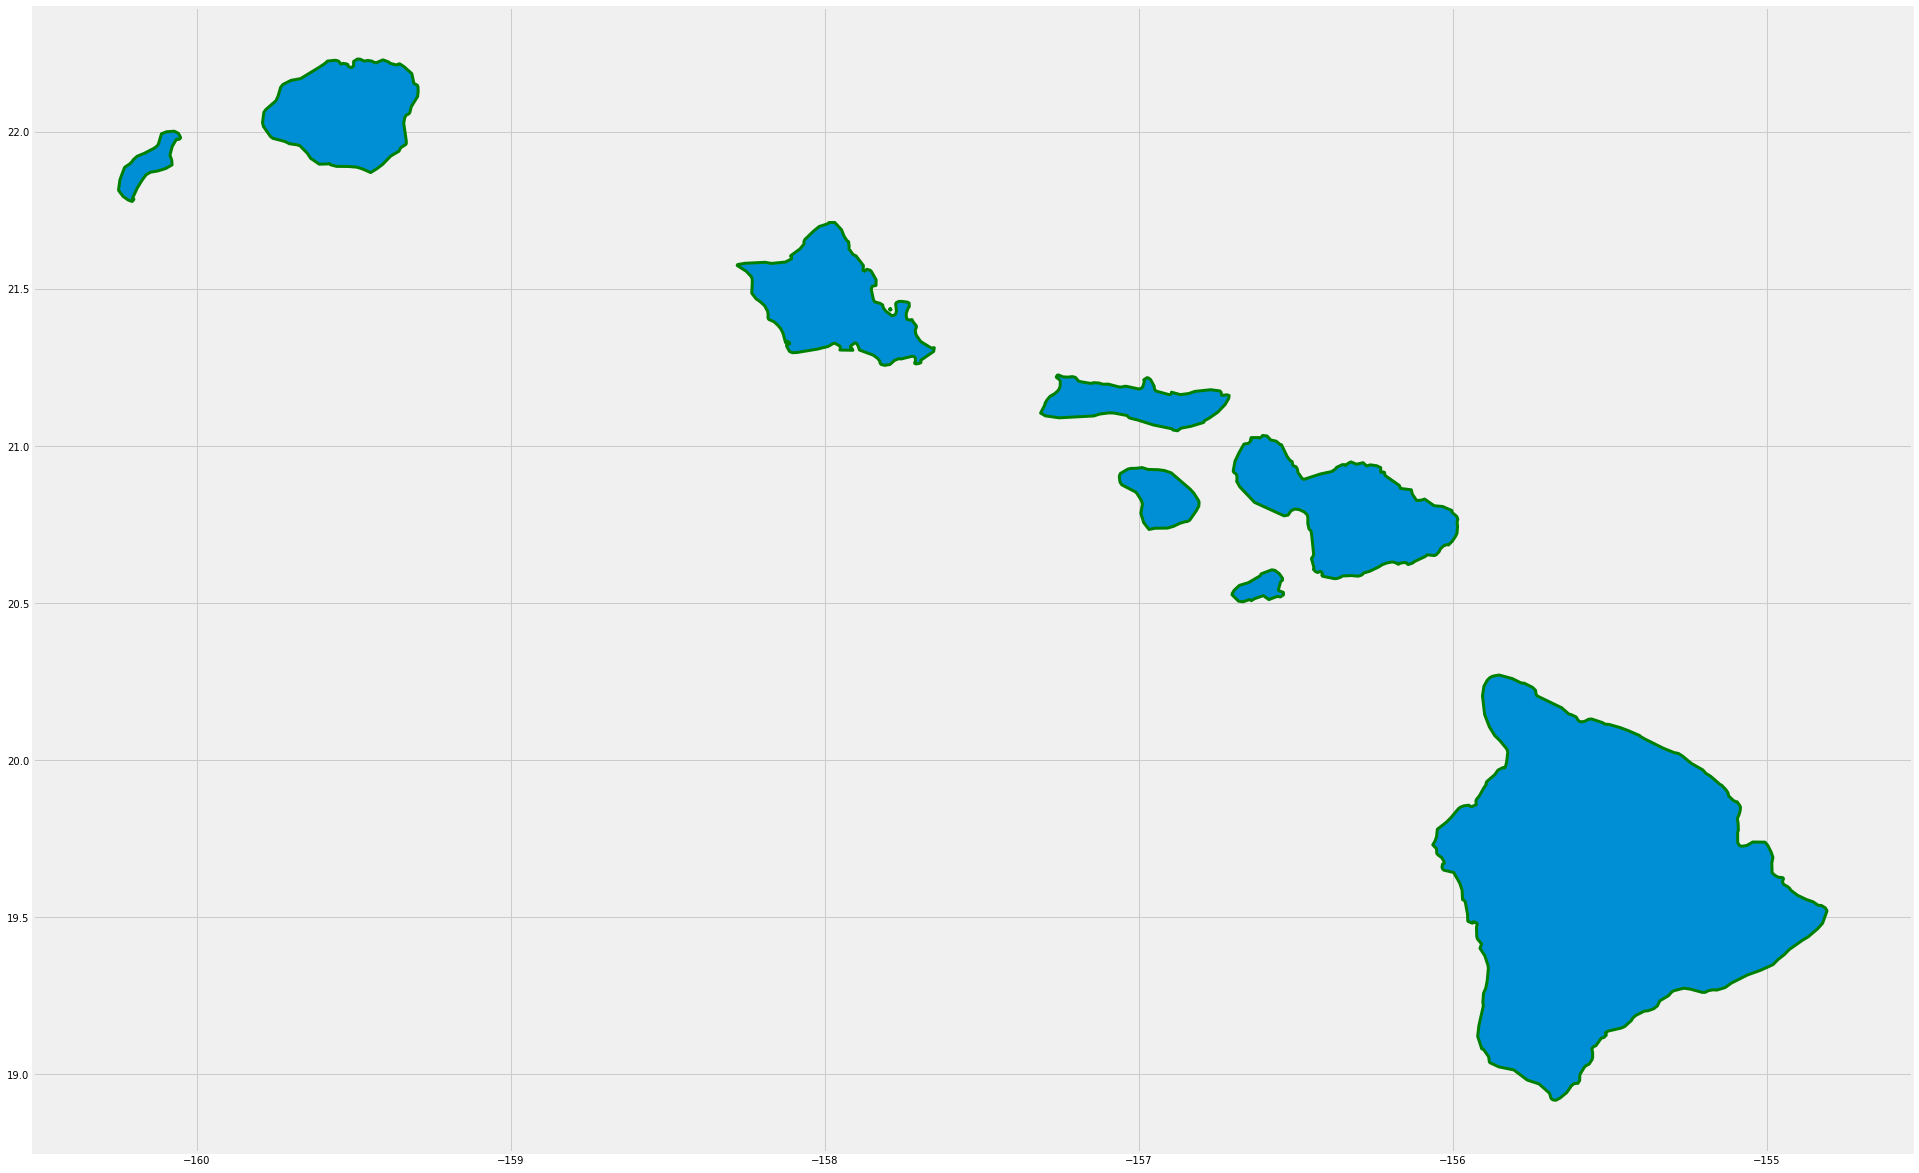

In [35]:
# Plot Alaska and Hawaii separately for formatting purposes
plot_states(['HI'],nongrowth_states.StateCode, us_map=False)
plt.savefig('hawaii_map.png')

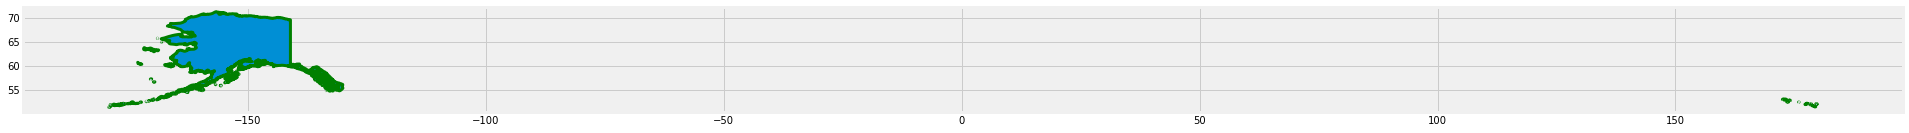

In [36]:
plot_states(['AK'],nongrowth_states.StateCode,us_map=False)
plt.savefig('alaska_map.png')

In [37]:
# Export station count and sales data for states with growing EV demand into csv file
growth_states.to_csv('growth_states.csv',index=False)
df.to_csv('ev_sales.csv',index=False)